# Network Infrastructure


### Description

Network topology is at the heart of today's hierarchacal internet infrastructure, from connecting machines in an office to datacenters between continients. ISP and private companies would like to provide connectivity and performance while reducing the amount of infrastructure and overall costs they must incur.

We consider the task of a major Internet company (e.g. Google) or cable company tasked with the role of connecting major cities across the US. The company is seeking to install fiber optic cables between major cities (e.g. connecting data centers). However, installing network cables are no cheap feat, so there are incentives to reducing the amount of cabling used as well as using cheaper cables on certain regions. However, the company would also like to maximize performance by maximizing bandiwidth over the whole network. 

A network of routers send packets from one router to another from source to destination. In reality, the path that an Internet packet can follow across this hierarchacal network can very unpredictable due to various routing protocols and packet switching between multiple organizations. However, on our organization's fiber optic network, we assume that packets received at one data center will be routed on the "fastest" path across our network (which we know a-priori) to the destination data center (before being passed on to the local routers). 




### A Brief History


### Importance, Relevance


### Data Source
Our choice of sample cities is based upon Zayo's current distribution of US-based data centers for its fiber optic network. Zayo offers a fiber optic network infrastructure, with centers in most major cities. We have removed several cities which were located closely to other cities (within 50 miles, such as Irvine, CA) and added several other major cities for analytical purposes.

### Assumptions
We will operate under the generalization that each mile of fiber optic, for a given type of wire, has a constant cost. This estimate excludes upfront all fixed and long term costs of maintainance, management, etc. Hence, the cost becomes directly proportional to the distance across all wires.

We also assume that the fiber optic cables can be run directly between locations in a "straight" line (on a curved Earth). This means we ignore the ramifications of infrastructure, geography, and socioeconomic policy which would affect the costs and feasibility of these installation routes. For our distance measures between locations, we use the Vincenty formula, which approximates straight line distances on an elipsoidal Earth. 

In [2]:
using JuMP
using Ipopt
using Clp
using NamedArrays
using PyPlot
using Interact

INFO: Precompiling module NamedArrays...
INFO: Precompiling module PyPlot...


/Users/patron/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [39]:
# Min data set for testing

centers = ["Boston","LA","Chicago","Dallas"];

raw = [
    0 2600 850 1500;
    2600 0 1700 1300; 
    850 1700 0 805;
    1500 1300 805 0;
];

distance = NamedArray(raw, (centers,centers), ("from","to"));
n = length(centers);

data = [ 
    42.3601 -71.0589;
    34.0522 -118.2437;
    41.8781 -87.6298;
    32.7767 -96.7970;
];
lat = Dict(zip(centers,data[:,1]));
lon = Dict(zip(centers,data[:,2]));


In [71]:
# Zayo Data centers
centers = [
    "Ashburn, VA", 
    "Atlanta, GA",
    "Austin, TX",
    "Boise, ID",
    "Boston, MA",
    "Chicago, IL",
    "Cincinnati, OH",
    "Dallas, TX",
    "Denver, CO",
    "Las Vegas, NV",
    "Los Angeles, CA",
    "Miami, FL", 
    "Minneapolis, MN",
    "Nashville, TN",
    "New York, NY",
    "Palo Alto, CA",
    "Seattle, WA"
];

raw = [
0 530.09 1298.47 2019.68 407.64 568.43 377.67 1163.11 1466.9 2061.18 2274.22 927.81 907.4 546.61 219.44 2408.07 2301.47; 
530.09 0 819.05 1835.68 936.77 587.61 369.12 720.98 1211.82 1746.3 1936.72 604.25 907.48 214.41 747.91 2127.93 2182.0;
1298.47 819.05 0 1369.13 1695.9 978.7 966.71 181.41 770.49 1084.97 1227.24 1114.85 1043.11 753.26 1514.07 1483.42 1770.16; 
2019.68 1835.68 1369.13 0 2260.77 1451.59 1666.27 1288.75 638.33 517.03 668.68 2363.43 1137.39 1636.24 2153.05 528.88 404.84; 
407.64 936.77 1695.9 2260.77 0 850.51 740.15 1551.6 1769.63 2375.49 2596.47 1255.68 1123.74 942.98 188.88 2695.68 2492.19; 
568.43 587.61 978.7 1451.59 850.51 0 251.98 804.53 920.44 1525.31 1745.96 1188.01 355.4 396.76 713.32 1854.17 1737.66; 
377.67 369.12 966.71 1666.27 740.15 251.98 0 814.07 1093.91 1684.43 1896.68 952.06 605.37 237.64 570.01 2035.78 1971.4; 
1163.11 720.98 181.41 1288.75 1551.6 804.53 814.07 0 662.38 1071.64 1240.4 1110.68 862.67 617.53 1374.14 1467.73 1681.41; 
1466.9 1211.82 770.49 638.33 1769.63 920.44 1093.91 662.38 0 606.85 831.19 1725.4 699.41 1022.67 1632.05 941.87 1021.34; 
2061.18 1746.3 1084.97 517.03 2375.49 1525.31 1684.43 1071.64 606.85 0 227.85 2181.13 1296.22 1580.67 2234.21 398.66 871.0; 
2274.22 1936.72 1227.24 668.68 2596.47 1745.96 1896.68 1240.4 831.19 227.85 0 2339.02 1523.57 1780.85 2451.84 320.99 958.82; 
927.81 604.25 1114.85 2363.43 1255.68 1188.01 952.06 1110.68 1725.4 2181.13 2339.02 0 1511.2 814.76 1090.82 2578.14 2733.5;
907.4 907.48 1043.11 1137.39 1123.74 355.4 605.37 862.67 699.41 1296.22 1523.57 1511.2 0 697.01 1019.23 1583.16 1395.08; 
546.61 214.41 753.26 1636.24 942.98 396.76 237.64 617.53 1022.67 1580.67 1780.85 814.76 697.01 0 760.88 1952.83 1974.66;
219.44 747.91 1514.07 2153.05 188.88 713.32 570.01 1374.14 1632.05 2234.21 2451.84 1090.82 1019.23 760.88 0 2567.48 2408.45;
2408.07 2127.93 1483.42 528.88 2695.68 1854.17 2035.78 1467.73 941.87 398.66 320.99 2578.14 1583.16 1952.83 2567.48 0 701.45; 
2301.47 2182.0 1770.16 404.84 2492.19 1737.66 1971.4 1681.41 1021.34 871.0 958.82 2733.5 1395.08 1974.66 2408.45 701.45 0;
];

distance = NamedArray(raw, (centers,centers), ("from","to"))
n = length(centers)

data = [
39.0437192 -77.4874898;
33.7490987 -84.3901848;
30.2711286 -97.7436994;
43.61656 -116.2008349;
42.3604823 -71.0595677;
41.8755546 -87.6244211;
39.1014537 -84.5124601;
32.7762719 -96.7968558;
39.7391536 -104.9847033;
36.1662859 -115.1492249;
34.0543942 -118.2439408;
25.7742658 -80.1936588;
44.9772995 -93.2654691;
36.1622296 -86.774353;
40.7305991 -73.9865811;
37.442156 -122.1634471;
47.6038321 -122.3300623;
];
lat = Dict(zip(centers,data[:,1]));
lon = Dict(zip(centers,data[:,2]));

In [22]:
# Helper functions

# US Map plotter; Credits to Laurent Lessard
# Generates a US plot of graph solution based on "edge" decision variable
using PyPlot
using PyCall
@pyimport mpl_toolkits.basemap as basemap

function mapSolution(x=0)
    m=basemap.Basemap(projection="merc", resolution="l",llcrnrlat=23,llcrnrlon=-126,urcrnrlat=50,urcrnrlon=-70)
    m[:drawmapboundary](fill_color="#4771a5")
    m[:fillcontinents](color="#555555")

    # plot airports
    for i in centers
        m[:plot](lon[i], lat[i], "ro" ,latlon=true)
    end
    
    for i in centers
        for j in centers
            if x[i,j] > 0.1
                m[:drawgreatcircle](lon[i],lat[i],lon[j],lat[j],linewidth=1,color="b")
            end
        end
    end
end;

# Subset generator:
# Given a number n, it generators all subsets of the set {1,2,...,n}
# Returns array of arrays, each array representing a subset
function genSubsets(nn)
    if (nn==1)
        return Array[[1],[]]
    else
        sol = genSubsets(nn-1);
        for i in 1:length(sol)
            push!(sol,[sol[i];nn])
        end
        return sol
    end
end;

# Optimal Min Cost

## Min Spanning Tree
http://www.columbia.edu/~cs2035/courses/ieor6614.S16/mst-lp.pdf

Seeking a connected undirected graph with minimal cost, we look at minimum spanning trees. In our graph, each potential edge from $i \rightarrow j$ has an associated cost $c*d_{i,j}$. Minimizing the cost of our network is equivalent in minimizing the sum of costs of every edge we include in our network. However, we would like a connected graph such that data from any node can reach any other node. The minimum spanning tree provides the optimial connected subgraph with minimum total edge cost [See 4]. We use the subtour formulation of the min-spanning tree problem from [see 5].

### Decision variables:

Binary indicator for whether edge between i,j exists in our solution network:

$
\being{gather}
\begin{aligned}
x_{i,j} \in {\{0,1\}} && \forall i,j \in V
\end{aligned}
\end{gather}
$

### Constraints:

The minimum spanning tree, as a tree, must have exactly n-1 edges:

$
\sum_{i,j \in V}{x_{i,j} = n-1}
$

Our tree should not have any self loops:

$
\begin{aligned}
x_{i,i}=0 && \forall i \in V
\end{aligned}
$

To prevent disconnected components, we use a subtour elimination constraint that prevents cycles. To do so, we consider every possible subset of nodes S and require that the induced subgraph (that is, the subgraph with edges only between these points) must have less than $|S|-1$ edges. This does require us to generate and enummerate $2^{n}$ constraints since there are $2^{n}$ possible subsets; note that we can ignore trivial and singular subsets (one node subgraph has L-1=0 nodes automatically when enforcing no self-loops). 

$\sum_{i,j \in S}{x_{i,j} \leq |S|-1}$ for all $\forall S \subset V$

### Objective: 
Our choice of edges in our subgraph seeks to minimize the total cost across all included edge weights. To do so, we calculate the weighted sum of each edges' weight with $x_{i,j}$, the binary indicator of whether it is included in our subgraph:

min $\sum_{i \in V}\sum_{j \in V}c_{i,j}*x_{i,j}$ 


Overall, our problem becomes:

$
\begin{aligned}
\underset{x \in \mathbb{R^n}}{\text{minimize}}\qquad& \sum_{i \in V}\sum_{j \in V}c_{i,j}*x_{i,j} \\
\text{subject to:}\qquad& \sum_{i,j \in S}{x_{i,j} \leq |S|-1} && \forall S \subset V\\
& \sum_{i,j \in V}{x_{i,j} = n-1} \\
& x_{i,i}=0 && i \in V \\
& x_{i,j} \in {\{0,1\}} && i,j \in V
\end{aligned}
$

In [17]:
m = Model();
@variable(m, edge[centers,centers], Bin)
@constraint(m, sum(edge) == n-1) # Min spanning tree requirement
@objective(m, Min, sum{edge[i,j]*distance[i,j], i in centers, j in centers})
for i in centers
    @constraint(m,edge[i,i]==0)
end
subsets = genSubsets(n)
for arr in subsets
    L = length(arr)
    if L > 1
        @constraint(m, sum{ edge[centers[i],centers[j]], i in arr, j in arr } <= L-1)
    end
end
solve(m)
#println(getvalue(edge))
println("Cost of Network: ",getobjectivevalue(m))

Cost of Network:5988.549999999999


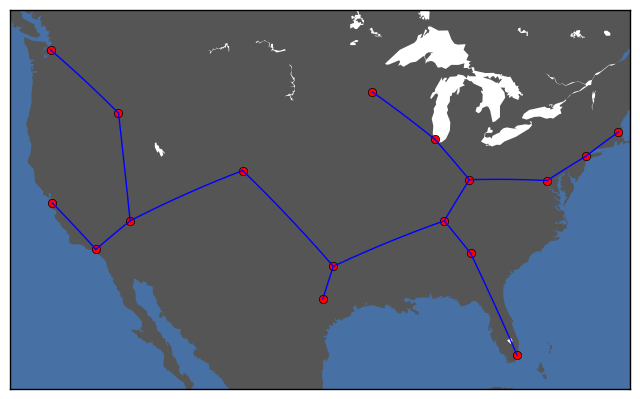

In [18]:
mapSolution(getvalue(edge))

# Connected graphs

While the previous min spanning tree model manages to find the minimal tree which connects all the nodes, the model does not allow for more generalized connected graphs for classes of problems. Also, the performance was slow, with the model not running on some of our machines. We sought a more generalized model that would allow for non-tree networks, which could be used in trade off analysis

Here, we attempt to calculate the optimium subgraph using a network flow "subproblem". Here, we attempt to find a subgraph with all vertices for which there exists atleast 1 path from a chosen node to every other node, implying that the subgraph is connected. To do so, we fix some node as a source with supply flow of n-1 units. Then we then set every other node as a sink with demand of 1 unit. Every edge can have unlimited flow across it. The only way for this supply and demand to be satisfied is for the supply to be distributed across all nodes, each consuming 1 unit of this flow; that is, there must exist atleast 1 path for the flow from this source to every sink. Hence, we much choose edges in our subgraph such that this flow problem "constraints" have some solution, implying connectivity. To achieve the cheapest such subgraph, we minimize the weighed sum of the edges chosen with their weights.

We make a quick note that because we are allowing connections between any pairs of cities/nodes, we are considering any edges between any nodes $i,j \in V$ (as opposed to $i,j \in V$ s.t. $(i,j) \in E$, which is equivalent but for general graphs.)

# Model
## Objective function:

Decision variables:
We use $x_{i,j}$ as an indicator whether the edge from i to j is included within our subgraph solution. This is a binary indicator variable:

$x_{i,j} \in {0,1},\forall i,j \in V$

We use a nonnegative variable to encode information about the network flow between nodes i and j, as part of the connectivity solution:

$flow_{i,j} \geq 0,\forall i,j \in V$

Our choice of edges in our subgraph seeks to minimize the total cost, or equivalently, the total distance across all included edge weights. To do so, we calculate the weighted sum of each edges' weight with $x_{i,j}$, the binary indicator of whether it is included in our subgraph.

min $\sum_{i \in V}\sum_{j \in V}c_{i,j}*x_{i,j}$ 


Constraints:

We do not want to consider self loops on nodes as prospective edges.
$x_{i,i}=0,\forall i \in V$
$flow_{i,i}=0,\forall i \in V$

For node 1, we have a source node with n-1 unit supply. We utilize the conservation of flow equations to form this constraint:
$(n-1)+\sum_{j \in V} flow_{j,1}*x_{j,1}-\sum_{j \in V} flow_{1,j}*x_{1,j} = 0$

For all nodes $i \in V$ with $i \neq 1$
$\sum_{j \in V} flow_{j,i}*x_{j,i}-\sum_{j \in V} flow_{i,j}*x_{i,j} = 1$

We would like to encode the following constaint to force flows only over edges that are "included". That is:
If there exists a flow from nodes i to j for $i,j \in V$, then $x_{i,j}=1$

Noting that the max flow over any edge is n-1 because there is only n-1 supply over the whole network (from node 1), we can use this as an upper limit to write an equivalent inequality constraint:
$(n-1)*x_{i,j} >= flow_{i,j}$ for all $i,j \in V$

5988.549999999999


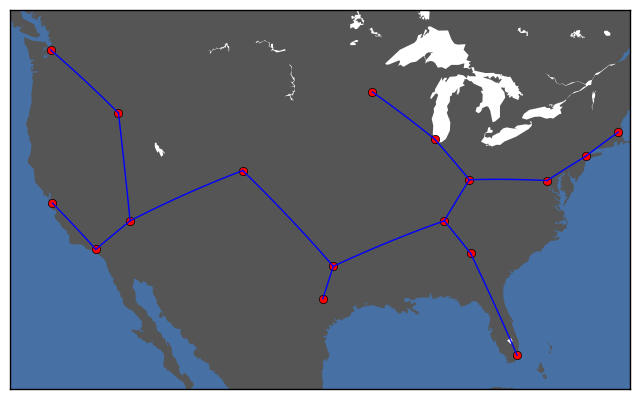

In [56]:
m = Model()
@variable(m, edge[centers,centers], Bin)

#Connectivity requirement
@variable(m, flow[centers,centers] >=0) #how much flow over edge (no upper limit)
for i in centers
    @constraint(m, edge[i,i]==0)
    @constraint(m, flow[i,i]==0)
    for j in centers
        @constraint(m,flow[i,j] <= (n-1)*edge[i,j]) # encodes "if flow >0, then edge==1" 
    end
    
    if (i==centers[1])
        @constraint(m, n-1 + sum{flow[c,i], c=centers} - sum{flow[i,c], c in centers} ==0) # center 1 has (n-1 inflow,)
    else
        @constraint(m, sum{flow[c,i], c=centers}-sum{flow[i,c], c in centers}==1) #Every other node has 1 outflow
    end
end

@objective(m, Min, sum{edge[i,j]*distance[i,j], i in centers, j in centers})
#Connectivity constraint as a max-flow problem.

s=solve(m)
#println(getvalue(edge))
println(getobjectivevalue(m))
mapSolution(getvalue(edge))

Min Flow

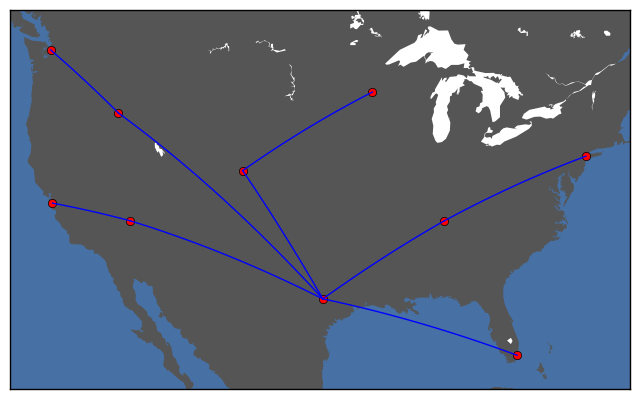

In [64]:
m = Model()
@variable(m, edge[centers,centers], Bin)

#Connectivity requirement
@variable(m, 2>= flow[centers,centers] >=0) #how much flow over edge (no upper limit)
for i in centers
    @constraint(m, edge[i,i]==0)
    @constraint(m, flow[i,i]==0)
    for j in centers
        @constraint(m,flow[i,j] <= (n-1)*edge[i,j]) # encodes "if flow >0, then edge==1" 
    end
    
    if (i==centers[1])
        @constraint(m, n-1 + sum{flow[c,i], c=centers} - sum{flow[i,c], c in centers} ==0) # center 1 has (n-1 inflow,)
    else
        @constraint(m, sum{flow[c,i], c=centers}-sum{flow[i,c], c in centers}==1) #Every other node has 1 outflow
    end
end

@objective(m, Min, sum{edge[i,j]*distance[i,j], i in centers, j in centers})
#Connectivity constraint as a max-flow problem.

s=solve(m)
#println(getvalue(edge))
#println(getvalue(flow))
mapSolution(getvalue(edge))

## Diameter Constrainted

Latency issues can arise if data must be routed indirectly before reaching its destination. To meet performance requirements, we may like to restrict the max distance any data must travel between centers.

Here, we would like to extend the above problem to restrict the diameter of the subgraph to some maximum distance. That is, the minimum distance between any 2 vertices along the subgraph must not exceed this value.

http://www.dcc.ic.uff.br/~celso/artigos/cpdcmst.pdf


In [60]:
# Zayo Data centers
centers = [
    "Austin, TX",
    "Boise, ID",
    "Denver, CO",
    "Las Vegas, NV",
    "Miami, FL", 
    "Minneapolis, MN",
    "Nashville, TN",
    "New York, NY",
    "Palo Alto, CA",
    "Seattle, WA"
];

raw = [
0 1369.13 770.49 1084.97 1114.85 1043.11 753.26 1514.07 1483.42 1770.16; 
1369.13 0 638.33 517.03 2363.43 1137.39 1636.24 2153.05 528.88 404.84; 
770.49 638.33 0 606.85 1725.4 699.41 1022.67 1632.05 941.87 1021.34; 
1084.97 517.03 606.85 0 2181.13 1296.22 1580.67 2234.21 398.66 871.0; 
1114.85 2363.43 1725.4 2181.13 0 1511.2 814.76 1090.82 2578.14 2733.5; 
1043.11 1137.39 699.41 1296.22 1511.2 0 697.01 1019.23 1583.16 1395.08; 
753.26 1636.24 1022.67 1580.67 814.76 697.01 0 760.88 1952.83 1974.66;
1514.07 2153.05 1632.05 2234.21 1090.82 1019.23 760.88 0 2567.48 2408.45; 
1483.42 528.88 941.87 398.66 2578.14 1583.16 1952.83 2567.48 0 701.45; 
1770.16 404.84 1021.34 871.0 2733.5 1395.08 1974.66 2408.45 701.45 0;
    ];

distance = NamedArray(raw, (centers,centers), ("from","to"))
n = length(centers)

data = [
30.2711286 -97.7436994;
43.61656 -116.2008349;
39.7391536 -104.9847033;
36.1662859 -115.1492249;
25.7742658 -80.1936588;
44.9772995 -93.2654691;
36.1622296 -86.774353;
40.7305991 -73.9865811;
37.442156 -122.1634471;
47.6038321 -122.3300623;
];
lat = Dict(zip(centers,data[:,1]));
lon = Dict(zip(centers,data[:,2]));

In [72]:
# Even D case
D = 4;
L = D/2;
m = Model()
@variable(m, edge[centers,centers], Bin)
@variable(m, 1 <= u[centers] <= L+1)

#Connectivity requirement
@variable(m, flow[centers,centers] >=0) #how much flow over edge (no upper limit)
for i in centers
    @constraint(m, edge[i,i]==0)
    @constraint(m, flow[i,i]==0)
    for j in centers
        @constraint(m,flow[i,j] <= (n-1)*edge[i,j]) # encodes "if flow >0, then edge==1" 
    end
    
    if (i==centers[1])
        @constraint(m, n-1 - sum{flow[i,c], c in centers} ==0) # center 1 has (n-1 inflow,)
    else
        @constraint(m, sum{flow[c,i], c=centers}-sum{flow[i,c], c in centers}==1) #Every other node has 1 outflow
    end
end


#@constraint(m, sum(r_edge)==1);
#for j in centers
#    @constraint(m,sum{edge[i,j],i in centers}+r_edge["r",j]==1);
#end
#@constraint(m, u[start,start] == 0.0 )
for i in centers
    for j in centers
        @constraint(m, u[i]-u[j]+(D+1)*edge[i,j] <= D);
    end
end

#for j in centers
#    @constraint(m, u["r"]-u[j]+(L+1)*r_edge["r",j] <= L);
#end

for i in centers
    @constraint(m,edge[i,i]==0)
end

@objective(m, Min, sum{edge[i,j]*distance[i,j], i in centers, j in centers})

s=solve(m)
#println(getvalue(edge))
println(getobjectivevalue(m))
mapSolution(getvalue(edge))



LoadError: LoadError: Internal error: Unrecognized solution status
while loading In[72], in expression starting on line 46

In [70]:
print(getvalue(flow))

flow: 2 dimensions:
[     Austin, TX,:]
  [     Austin, TX,     Austin, TX] = 0.0
  [     Austin, TX,      Boise, ID] = 1.0
  [     Austin, TX,     Denver, CO] = 1.0
  [     Austin, TX,  Las Vegas, NV] = 1.0
  [     Austin, TX,      Miami, FL] = 1.0
  [     Austin, TX,Minneapolis, MN] = 1.0
  [     Austin, TX,  Nashville, TN] = 0.9999999999999992
  [     Austin, TX,   New York, NY] = 1.0
  [     Austin, TX,  Palo Alto, CA] = 1.0
  [     Austin, TX,    Seattle, WA] = 1.0
[      Boise, ID,:]
  [      Boise, ID,     Austin, TX] = 0.0
  [      Boise, ID,      Boise, ID] = 0.0
  [      Boise, ID,     Denver, CO] = 0.0
  [      Boise, ID,  Las Vegas, NV] = 0.0
  [      Boise, ID,      Miami, FL] = 0.0
  [      Boise, ID,Minneapolis, MN] = 0.0
  [      Boise, ID,  Nashville, TN] = 0.0
  [      Boise, ID,   New York, NY] = 0.0
  [      Boise, ID,  Palo Alto, CA] = 0.0
  [      Boise, ID,    Seattle, WA] = 0.0
[     Denver, CO,:]
  [     Denver, CO,     Austin, TX] = 0.0
  [     Denver, CO,    

In [52]:
print(getvalue(u))
print(L)

u: 1 dimensions:
[     Austin, TX] = 0.0
[      Boise, ID] = 1.0
[     Denver, CO] = 2.0
[  Las Vegas, NV] = 2.0
[      Miami, FL] = 2.0
[Minneapolis, MN] = 2.0
[  Nashville, TN] = 1.0
[   New York, NY] = 2.0
[  Palo Alto, CA] = 2.0
[    Seattle, WA] = 2.0
1.0

# Results

In [ ]:
Cost of our optimal solution:

Map of our best solution:



# Conclusions

# Bibliography

https://en.wikiversity.org/wiki/Introduction_to_graph_theory/Proof_of_Theorem_4